In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image

import cv2

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import (train_test_split,cross_val_predict,cross_val_score
                                     ,RandomizedSearchCV,GridSearchCV)
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.metrics import (f1_score,precision_recall_curve,precision_score
                             ,recall_score,ConfusionMatrixDisplay)

from plyer import notification


In [2]:
def alert():
    notification.notify(
    title = "Python",
    message = "Execution Completed",
    timeout = 10
    )
    

In [3]:
test_dir = "dataset/test/"
train_dir = "dataset/train/"

classes = os.listdir(train_dir)
classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

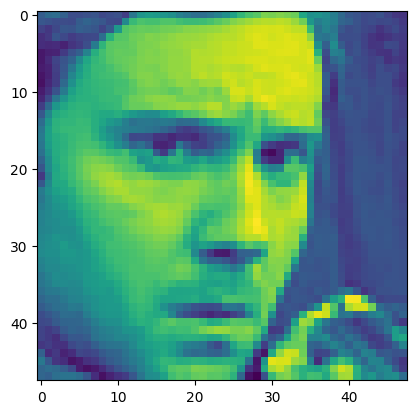

In [4]:
data = np.asarray(Image.open(r"dataset\train\angry\im0.png"))
# plt.imshow(data)
data = data.reshape(48*48)
plt.imshow(data.reshape(48,48))

In [5]:
x_train = []
y_train = []

In [6]:
encoded_classes = [i for i in range(len(classes))]

for i in range(len(classes)):
    datalist = os.listdir(train_dir+classes[i])
    for j in datalist[:1000]:
        data = np.asarray(Image.open(train_dir+classes[i]+"/"+j))
        data_norm = cv2.normalize(data.flatten(),None,0,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
        x_train.append(data_norm.flatten())
        y_train.append(encoded_classes[i])
        

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)


(6436, 2304)


In [7]:
def image_show(img):
    data = img.reshape(48,48)
    plt.imshow(cv2.cvtColor(data,cv2.COLOR_BGR2RGB))
    plt.show()

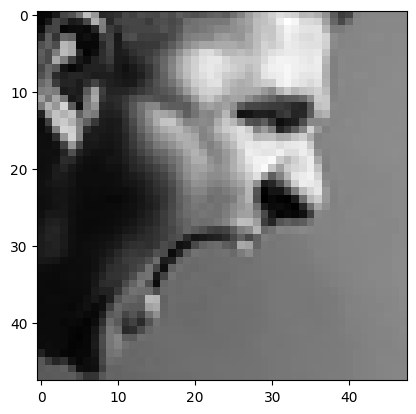

1324


In [8]:
image_show(x_train[10])
print(x_train[0].argmax())

In [9]:
x_train.shape

(6436, 2304)

4


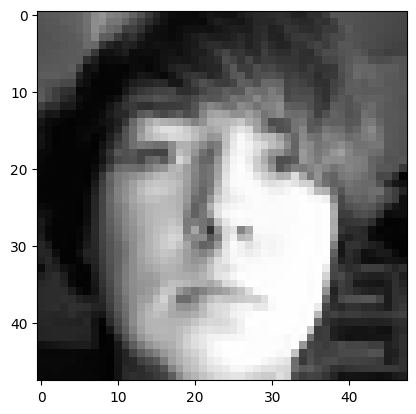

In [10]:
print(y_train[4000])
image_show(x_train[4000])

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.1,random_state=30)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5792, 2304)
(5792,)
(644, 2304)
(644,)


In [13]:
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

In [14]:
x_train_scaled[0]


array([ 0.78823686,  0.8466948 ,  1.1754549 , ..., -0.20822097,
       -0.23922019, -0.33580893], dtype=float32)

In [15]:
# ord_encdr = OrdinalEncoder()
# y_train_encoded = ord_encdr.fit_transform(y_train.reshape(-1,1))

In [16]:
# ord_encdr.categories_

In [17]:
rnd_model = RandomForestClassifier(
                                  n_jobs=2,
                                  verbose=1)

In [18]:
n_estimators = [100]
max_depth = [5]
min_samples_split = [2]
min_samples_leaf = [1] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rnd_model, hyperF, cv = 3, verbose = 2, 
                      n_jobs = 3)
bestF = gridF.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   11.8s finished


In [24]:
import json
import os 
from discord import SyncWebhook

with open("parameter.json","w") as f:
    json.dump(gridF.best_params_,f)
    


webhook = SyncWebhook.from_url("https://discord.com/api/webhooks/1063122746835472466/QWFwQkRFXRtRLa0j21nvMl2D7qQooBs3OiAun2SEwlwSFf0UegILx4SXKxKQ_Gq7FjEr")
webhook.send(f"```{gridF.best_params_}```")
    
os.system("shutdown /s /t 1")

In [ ]:
# rnd_model.fit(x_train,y_train)

In [ ]:
# pred = cross_val_score(rnd_model,x_train_scaled[:1000],y_train[:1000],cv=3,scoring="accuracy")
# print(pred)


In [ ]:
# pred.mean()